# Maurice *et al*., *PSJ* 2023
Reproduce simulations from [Maurice *et al*., PSJ, 2023](https://iopscience.iop.org/article/10.3847/PSJ/acb2ca)     
by Maxime Maurice (maxime.maurice@protonmail.com)   
- For fractional/equilibrium crystallization: comment/uncomment the desried code sippets
- For initial fO2: chose p_eq in box "Core-mantle equilibration effective $P$-$T$ conditions"
- For initial H budget and C/H: set value in box "Model parameters"

### Dependencies and Packages

In [1]:
from physics.constants import *
from physics import eos,viscosity
from physics.phase_change.refractories import mc_book
from chemistry.elements import *
from chemistry.molecules import *
from chemistry.equilibria import *
from chemistry.redox import *
from datapath import datapath
from atmospheres import atmosphere, multi_species_single_condensible_convective_atmosphere
from petitRADTRANS import Radtrans
from utils import y2s
import matplotlib.pyplot as plt

# For equilibrium crystallization
from magma_ocean import magma_ocean
# For fractional crystallization
#from magma_ocean import fractional_crystallization as magma_ocean

%matplotlib inline

### case-specific settings

In [2]:
eq_C.coefs[O2]      = 0
eq_H.coefs[O2]      = 0

albedo              = 0.2
faint_young_sun     = 0.75
solar_const         = 1367.6 # [W/m^2]
stellar_irradiation = 1./4*solar_const*(1.-albedo)*faint_young_sun

R_planet            = Earth_surface_radius # 6371000 # [m]
g_planet            = Earth_gravity # 9.798 # [m/s^2]

T_pot               = 3000 # [K] corresponds to nothing particular, will overwritten
p_CMB               = 135e9 # [Pa]

## Magma Ocean

### Prepare EOS

In [3]:
from burnman.minerals.DKS_2013_liquids import MgSiO3_liquid
# Equations of state for MgSiO3 liquid [de Koker and Stixrude 2013]

rho   = lambda p,T:MgSiO3_liquid().evaluate(['density'],p,T)
alpha = lambda p,T:MgSiO3_liquid().evaluate(['thermal_expansivity'],p,T)
cp    = lambda p,T:MgSiO3_liquid().evaluate(['C_p'],p,T)/MgSiO3_liquid().molar_mass

# Need to vectorize: burnman struggles otherwise
rho_vec   = np.vectorize(rho)
alpha_vec = np.vectorize(alpha)
cp_vec    = np.vectorize(cp)

### Create Magma Ocean

In [4]:
MO = magma_ocean(T_pot,
                 p_CMB,
                 eos={'rho':rho_vec,'alpha':alpha_vec,'cp':cp_vec},
                 g=g_planet,
                 R=R_planet,
                 ConvCum=True)

### melting curves

Text(0, 0.5, 'pressure [GPa]')

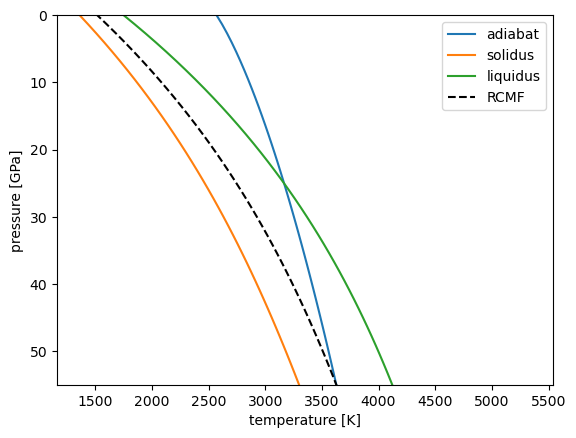

In [5]:
# For equilibrium crystallization
MO.setMeltingCurves(mc_book['Earth'],file=datapath+'/mc_lookups_equi_RCMF=0.4_MgSiO3_liquid_EOS.dat',p_bot=55e9,RCMF=0.4)
# For fractional crytallization
#MO.setMeltingCurves(mc_book['Earth'],file=datapath+'/mc_lookups_frac_MgSiO3_liquid_EOS.dat',p_bot=55e9)

# initialize potential temperature
MO.updateT_pot(MO.T_pot_lookup[np.argmin(abs(MO.p_bot_lookup-55e9))])
    
# plot
plt.plot(MO.profiles['temperatures'],MO.profiles['pressures']*1e-9,label='adiabat')
MO.mc.plot()
# For equilibrium crystallization: plot RCMF
plt.plot(MO.mc.getTsol(MO.profiles['pressures'])*(1-MO.mc.RCMF)+MO.mc.getTliq(MO.profiles['pressures'])*MO.mc.RCMF,MO.profiles['pressures']*1e-9,'--',c='k',label='RCMF')

plt.ylim(MO.p_bot*1e-9,0)
plt.legend()
plt.xlabel('temperature [K]')
plt.ylabel('pressure [GPa]')

### Viscosity law

In [6]:
# For equilibrium crystallization
def eta_mix(p,T,phi):
    if phi<MO.mc.RCMF:
        return 1e21 # [Pa s]: any large value will do: doesn't affect the harmonic mean
    else:
        return viscosity.viscosity_book['VFT'](T)/(1.-(1.-phi)/(1.-MO.mc.RCMF))**2.5
MO.setParametrization('viscosity',lambda var: np.vectorize(eta_mix)(var['pressures'],var['temperatures'],var['phi']),['temperatures','pressures','phi'])

# For fractional crystallization
#MO.setParametrization('viscosity',lambda var: viscosity.viscosity_book['VFT'](var['temperatures']),['temperatures'])

### boundary layer

In [7]:
MO.setParametrization('k',lambda var: 1e-6*var['rho']*var['cp'],['rho','cp']) # kappa = 1e-6 m^2/s
MO.addBoundaryLayer(1.) # 1 K temperature contrast accross the thermal boundary layer (will be overwritten when solving flux balance for T_sfc)

## Oxygen Fugacity

### Core-mantle equilibration effective $P$-$T$ conditions

In [8]:
# Initial condition on fO2
p_eq = MO.p_surf # IW-2 at surface
#p_eq = MO.p_bot # IW-2 at bottom
T_eq = MO.adiabat.getT(p_eq)

### ferrous- ferric-iron oxides
The partition coefficients are average values calculated for the crystallization sequence of the terrestrial MO from Elkins-Tanton 2008  
The initial Fe$^{3+}/\Sigma$Fe is calculated so that the $f_{O_2}$ at the core-mantle equilibration $p,T$ conditions is IW-2. In the present case, equilibration occurs at the bottom of the MO and $p_{\rm eq}=55$ GPa and $T_{\rm eq}$ is on the adiabat at  $p_{\rm eq}$.

In [9]:
from chemistry.partition_coefficients import get_part_coef
Fe_ferrous.part_coef     = 1

# For equilibrium crystallization
MO.setParametrization('D_Fe3+_profile',lambda var: get_part_coef(var['pressures'],'Fe3+','2000km'),['pressures'],is_profile=True)
def set_Fe_ferric_part_coef(MO):
    Fe_ferric.part_coef = MO.getAverage(MO.profiles['D_Fe3+_profile'],mass_weighted=True,domain=[MO.p_bot,MO.p_liq])
    return Fe_ferric.part_coef
MO.setParametrization('D_Fe3+_eff', lambda var: set_Fe_ferric_part_coef(var['MO']),[],is_profile=False)

# For fractional crystallization:
#def set_Fe_ferric_part_coef(p):
#    Fe_ferric.part_coef = get_part_coef(p,'Fe3+','2000km')
#    return Fe_ferric.part_coef
#MO.setParametrization('D_Fe3+_eff', lambda var: set_Fe_ferric_part_coef(var['p_bot']),['p_bot'],is_profile=False)

### Initial Fe$^{3+}/\Sigma$Fe in MO

In [10]:
# Fe3+/Fe2+ (molar) set by the initial condition (imposed by core-mantle equilibration): fO2(p_eq,T_eq,Fe3+/Fe2+) = IW-2
initial_molar_ferric_to_ferrous_iron_liq = ferric_to_ferrous_iron_H22(p_eq,                                # core-mantle equilibrium pressure
                                                                      T_eq,                                # core-mantle equilibrium temperature
                                                                      10**(fO2_buffers_H22(p_eq,T_eq)-2), # fO2(p_eq,T_eq) = IW-2
                                                                      BSE)                                # composition

Molar ratio-to-mass fraction conversion

In [11]:
total_iron_oxide_mass_fraction_BSE = (pd.read_excel(datapath+'/BSE_composition.ods',index_col=0,sheet_name='mass').T['Palme and Oneill 2003'])['FeO']/100

def molar_ratio_to_mass_frac(molar_ratio, total_mass_frac=total_iron_oxide_mass_fraction_BSE):
    Fe3p_mass_frac = molar_ratio*Fe_ferric.molecular_mass/Fe_ferrous.molecular_mass/(1+molar_ratio*Fe_ferric.molecular_mass/Fe_ferrous.molecular_mass)*total_mass_frac
    return Fe3p_mass_frac, total_mass_frac-Fe3p_mass_frac

In [12]:
MO.addSpecies([Fe_ferric,Fe_ferrous],
              [(MO.M_liquid+Fe_ferric.part_coef*MO.M_solid)/MO.M_system*molar_ratio_to_mass_frac(initial_molar_ferric_to_ferrous_iron_liq)[0],
               (MO.M_liquid+Fe_ferrous.part_coef*MO.M_solid)/MO.M_system*molar_ratio_to_mass_frac(initial_molar_ferric_to_ferrous_iron_liq)[1]])
MO.to_frac=['Fe3+','Fe2+']
MO.fractionation(MO.to_frac)
MO.setParametrization('Fe3+/FeT',lambda var:1/(1+1/(var['Fe3+_liquid']/var['Fe2+_liquid']*Fe_ferrous.molecular_mass/Fe_ferric.molecular_mass)),['Fe2+_liquid','Fe3+_liquid'],is_profile=False)

### Set $f_{O_2}$ parametrization from Hirschmann 2022

In [13]:
MO.setParametrization('fO2_sfc',
                      lambda var: fO2_sfc_H22(var['T_pot'],var['Fe3+/FeT'],BSE),
                      ['T_pot','Fe3+/FeT'],
                      is_profile=False)

### Redox equilibria

#### 2H$_2$+O$_2$=2H$_2$O

In [14]:
def K_H(variables):
    eq_H.constant = equilibrium_constant_NATAF[eq_H.expression](variables['T_pot'])*variables['fO2_sfc']
    return eq_H.constant
MO.setParametrization('K_H',K_H,['T_pot','fO2_sfc'],is_profile=False)

#### 2CO+O$_2$=2CO$_2$

In [15]:
def K_C(variables):
    eq_C.constant = equilibrium_constant_NATAF[eq_C.expression](variables['T_pot'])*variables['fO2_sfc']
    return eq_C.constant 
MO.setParametrization('K_C',K_C,['T_pot','fO2_sfc'],is_profile=False)

In [16]:
MO.to_spec=['H','C']

## Volatiles

### Model parameters

In [17]:
# non dimensional study parameters
H_budet_EO  = 9   # for the BSE, not just the MO
C2H_by_mass = 2

# bulk masses of volatiles in the system
H_mass_in_MO = H_budet_EO*EO_mass/BSE_mass*H2O.coefs[H]*H.atomic_mass/H2O.molecular_mass*MO.M_system
C_mass_in_MO = H_mass_in_MO*C2H_by_mass

### Calculate initial partial pressures

In [18]:
from tools import spec_iter

pp0 = spec_iter({H:H_mass_in_MO,
                 C:C_mass_in_MO,
                 'Msol':MO.M_solid,
                 'Mliq':MO.M_liquid,
                 'Sred':4*np.pi*MO.R_out**2/MO.gravity,
                 eq_H:eq_H.constant,
                 eq_C:eq_C.constant})

## Atmosphere

### Create atmosphere

In [19]:
MO.atm=multi_species_single_condensible_convective_atmosphere(np.array([g for g in pp0]),
                                                              np.array([pp0[g] for g in pp0]),
                                                              MO.adiabat.T_pot-MO.BL.Delta_T,R=MO.R_out,g=MO.gravity,
                                                              pToA=1,cond=H2O,T_str=200.)
MO.addSpecies([H2,H2O,CO,CO2],[0,H_mass_in_MO/MO.M_system*H2O.molecular_mass/H2O.coefs[H]/H.atomic_mass,
                               0,C_mass_in_MO/MO.M_system*CO2.molecular_mass/CO2.coefs[C]/C.atomic_mass],True)

### Load reference composition

In [20]:
MO.atm=multi_species_single_condensible_convective_atmosphere(np.array([g for g in pp0]),
                                                              np.array([pp0[g] for g in pp0]),
                                                              MO.atm.Ts,R=MO.R_out,g=MO.gravity,
                                                              pToA=1,cond=H2O,T_str=200.)

### Calculate speciation

In [21]:
MO.atm.equilibria=[eq_H.expression,eq_C.expression]
MO.speciation(MO.atm.equilibria,MO.to_spec)

## Radiative Transfer
We use petitRADTRANS (Mollière et al., 2019) to calculate the radiative flux through the atmosphere. We use pRT in correlated-$k$ mode with re-binned opacity coefficients (10 wavelength bins), allowing for significant speed-up.

### Create pRT object

In [22]:
species_order = [g.formula for g in MO.atm.gases]
MO.atm.radiation = Radtrans(line_species = [sp+'_R_10' for sp in species_order],
                            continuum_opacities = ['H2-H2'],
                            wlen_bords_micron = [0.1, 251.],
                            do_scat_emis = False)

/home/maxime/Models/Radiative_Transfer/pRT/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2_R_10...
 Done.
  Read line opacities of H2O_R_10...
 Done.
  Read line opacities of CO_R_10...
 Done.
  Read line opacities of CO2_R_10...
 Done.

  Read CIA opacities for H2-H2...
Done.



### Parametrization to update pRT

In [23]:
def update_rad_pres(var):
    MO.atm.radiation.setup_opa_structure(np.flipud(MO.atm.profiles['pressure'])*1e-5) # pRT reads pressures in bar! (and equidistant in pressure log-space)
    return 1.
MO.setParametrization('radPres',update_rad_pres,[],is_profile=False,channel='post-spec')    

### OLR

In [24]:
def getOLR():
    mass_fractions = {}
    mass_fractions['H2_R_10']  = np.flipud(MO.atm.profiles['mass fraction']['H2'])
    mass_fractions['H2']       = np.flipud(MO.atm.profiles['mass fraction']['H2'])
    mass_fractions['H2O_R_10'] = np.flipud(MO.atm.profiles['mass fraction']['H2O'])
    mass_fractions['CO_R_10']  = np.flipud(MO.atm.profiles['mass fraction']['CO'])
    mass_fractions['CO2_R_10'] = np.flipud(MO.atm.profiles['mass fraction']['CO2'])
        
    MO.atm.radiation.calc_flux(np.flipud(MO.atm.profiles['temperature']),\
                               mass_fractions,\
                               MO.gravity*100,\
                               np.flipud(MO.atm.profiles['average molecular mass']))
    return -np.trapz(MO.atm.radiation.flux,MO.atm.radiation.freq)*1e-7*1e4
MO.atm.getOLR=getOLR

### Flux Residual
The flux residual is the difference between the OLR calculated by the radiative model and the convective flux in the MO. It is the function that we minimized to obtain $T_{\rm surf}$

In [25]:
def flux_residual(MO,T):
    MO.updateBL(T)
    MO.atm.updateTs(T)
    return MO.BL.getFlux()+stellar_irradiation-MO.atm.getOLR()
MO.flux_residual = flux_residual

## Internal heating

In [26]:
from chemistry.isotopes import U235,U238,Th232,K40
t0 = 100*1e6*y2s
H_rad = BSE_mass*(U235.radio.getParentRatio(t=t0)*U235.heat\
                 +U238.radio.getParentRatio(t=t0)*U238.heat\
                 +Th232.radio.getParentRatio(t=t0)*Th232.heat\
                 +K40.radio.getParentRatio(t=t0)*K40.heat)
MO.setParametrization('radioactive_decay',lambda var:H_rad,[],channel='internal-heating',is_profile=False)

## Initialize

In [27]:
MO.dEth_dTpot = 8.34e+27 # [J/K]
MO.RK4_step(0.)

0.0

### Time-series
Stores the relevant quantities at each crystallization step

In [28]:
from tools import time_series
ts=time_series(MO)

# Add custom quantities
ts.register('OLR','atm.getOLR()')                          # Save OLR
ts.register('mu_atm','atm.average_molecular_mass')         # Save average molecular mass of the atmosphere
ts.register('p_tot','atm.ps')                              # Save surface pressure
ts.register('p_cloud','atm.cloud_deck')                    # Save lifting condensation level
ts.register('T_bot','adiabat.getT(self.attribute.p_bot)')  # Save temperature at the bottom of the MO
ts.register('Ra','getRa(\'liquid\')')                      # Save MO Rayleigh number

ts.write(0)

### Timestep
We set the initial and maximum timestep. The code has a built-in timestep 'adapater', which increases $dt$ when the potential temperature step is smaller than 1 K (since the flux only reduces with progress of the crystallization, there is no correction in the other direction).

In [29]:
MO.max_dT=10
dt = 1000*y2s

## Let's goooooooooo

In [30]:
while MO.M_system/ts('M_sys')[0] > 0.01:
    dt=MO.RK4_step(dt)
    ts.write(MO.t)
    print('M/M0=',MO.M_system/ts('M_sys')[0])

M/M0= 0.9785014326277096


M/M0= 0.9604549038797038


M/M0= 0.9436002408864076


M/M0= 0.927083547662536


M/M0= 0.9110117775045835


M/M0= 0.8951653893373782


M/M0= 0.8796405226391399


M/M0= 0.8645727126158594


M/M0= 0.8498296427627522


M/M0= 0.8352523503872034


M/M0= 0.8209121981035628


M/M0= 0.8071338369542843


M/M0= 0.7934037852119905


M/M0= 0.7798797157600159


M/M0= 0.766873209157762


M/M0= 0.7538463053570484


M/M0= 0.7411427676228999


M/M0= 0.7286798222372801


M/M0= 0.7164068681130286


M/M0= 0.7044023634135042


M/M0= 0.6924130639939098


M/M0= 0.680836982709109


M/M0= 0.6692864939660537


M/M0= 0.6580739180958074


M/M0= 0.6468021458661309


M/M0= 0.6359436208529602


M/M0= 0.6250852514615762


M/M0= 0.6145435398808786


M/M0= 0.6039699458517656


M/M0= 0.593679881342979


M/M0= 0.5835225018235592


M/M0= 0.5734163047863277


M/M0= 0.5635616022585955


M/M0= 0.5536602752784304


M/M0= 0.5441154273064578


M/M0= 0.5346018559707397


M/M0= 0.5251097931790447


M/M0= 0.5158988654399398


M/M0= 0.506644547180392


M/M0= 0.4975676830490736


M/M0= 0.4887106692689576


M/M0= 0.47971481178680814


M/M0= 0.4710127515474654


M/M0= 0.46235340756619364


M/M0= 0.45365008277009605


M/M0= 0.4452688861243627


M/M0= 0.43687970385118363


M/M0= 0.42842284909165146


M/M0= 0.42018314016901126


M/M0= 0.41205143089591506


M/M0= 0.40391576094859927


M/M0= 0.39579812693359967


M/M0= 0.3879400893410587


M/M0= 0.38002179115502216


M/M0= 0.3719950130771774


M/M0= 0.36442091273345295


M/M0= 0.3567364545758203


M/M0= 0.34899164447287495


M/M0= 0.34129714575466574


M/M0= 0.3338979598355161


M/M0= 0.32642111695261006


M/M0= 0.31892689787384004


M/M0= 0.31154314390189247


M/M0= 0.30433285471263954


M/M0= 0.29703789305658934


M/M0= 0.28966418352991324


M/M0= 0.2825391730362592


M/M0= 0.2755576968272157


M/M0= 0.26845647642877646


M/M0= 0.261329700668649


M/M0= 0.25430292947962513


M/M0= 0.24745080359798113


M/M0= 0.24053826677414022


M/M0= 0.23364486824426753


M/M0= 0.22664111802015754


M/M0= 0.21998331395716814


M/M0= 0.21336723647696101


M/M0= 0.2065655567073594


M/M0= 0.19968585562823452


M/M0= 0.19315627128947133


M/M0= 0.18661972478999056


M/M0= 0.1799994695687341


M/M0= 0.1732527672737803


M/M0= 0.16665596526136053


M/M0= 0.1600086605486094


M/M0= 0.1535650613679595


M/M0= 0.14721458646722452


M/M0= 0.14062758357584326


M/M0= 0.13403057565460175


M/M0= 0.1279647835456178


M/M0= 0.12160791448946459


M/M0= 0.11523256443446517


M/M0= 0.10895327417127418


M/M0= 0.10251167184395801


M/M0= 0.09636684697309504


M/M0= 0.09050297468694944


M/M0= 0.08412994986362711


M/M0= 0.07773494076001039


M/M0= 0.07173546198380579


M/M0= 0.06543170214391845


M/M0= 0.059175426105170605


M/M0= 0.05352499312260092


M/M0= 0.04715936875881248


M/M0= 0.04056338461421016


M/M0= 0.03484068606578791


M/M0= 0.02859310525744716


M/M0= 0.022275547219971267


M/M0= 0.0169334587440639


M/M0= 0.010508789157605298


M/M0= 0.004015909768850963
